In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import scipy
from antenna import Antenna
import itertools
from tqdm import tqdm

In [2]:
with open("../config.json", 'r') as cfg:
    params = json.load(cfg)

antenna_params = params["antenna_params"]
opt_params = params["optimisation_params"]

In [3]:
antenna_params['N'] = 12

In [4]:
antenna_params["wavelengths"]=[1, 2]
antenna = Antenna(antenna_params)
antenna.set_objective(weights=[1.0, 1.0])
antenna.set_jacobian(weights=[1.0, 1.0])
antenna.set_hessian(weights=[1.0, 1.0])

In [5]:
np.sqrt(abs(min(np.linalg.eigvals(antenna.afs[0].conj().T@antenna.afs[0])) * min(np.linalg.eigvals(antenna.afs[1].conj().T@antenna.afs[1]))))

0.03343270756112896

In [6]:
np.linalg.eigvals(antenna.afs[0].conj().T@antenna.afs[0])

array([550.24145702+6.06655773e-30j, 246.59488287-2.74290931e-29j,
       194.39041016+1.54294889e-30j, 166.09946462+9.66700973e-31j,
       149.91804709-3.24162550e-30j, 138.60367722+2.28273632e-29j,
       130.8684981 +1.14783099e-31j, 125.12380621+6.01907503e-29j,
       121.02746638-2.54201871e-28j, 118.06716058+1.79805021e-28j,
       114.96250134+2.91556814e-28j, 116.10262841+7.12610947e-28j])

In [7]:
A = scipy.linalg.block_diag(*antenna.afs)

In [8]:
b = np.concatenate((antenna.beams))

In [9]:
x = np.linalg.lstsq(A, b, rcond=None)

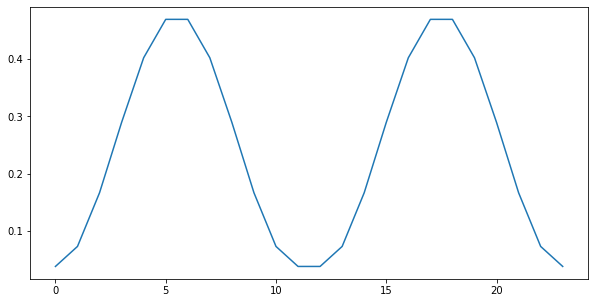

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(abs(x[0]))

In [11]:
B = np.block([[0*np.eye(antenna.N), np.eye(antenna.N)], [np.eye(antenna.N), 0*np.eye(antenna.N)]])

In [12]:
def f(x, eps=0.9):
    x = x.reshape(-1, 1)
    return np.linalg.norm(A@x - abs(b))**2 + eps*x.T@B@x

In [13]:
temp = []
temp_x = []
for i in tqdm(np.arange(0, 100, 0.1)):
    res = scipy.optimize.minimize(f, x0=np.ones(antenna.N * antenna.n_currents), args=(i, ), bounds=[(0, np.inf) for _ in range(antenna.N * antenna.n_currents)])
    temp.append(*res.fun)
    temp_x.append(res.x)

100%|██████████| 1000/1000 [00:16<00:00, 59.36it/s]


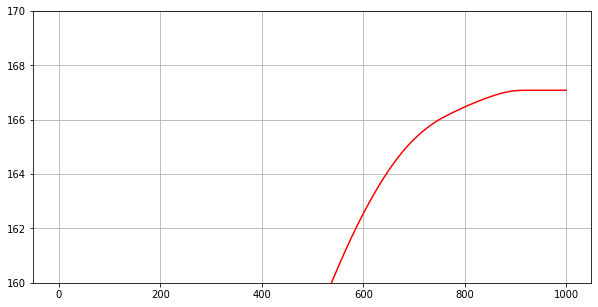

In [14]:
plt.figure(figsize=(10, 5))
plt.plot([np.linalg.norm(x) for x in temp_x], 'k')
plt.plot(temp, 'r')
plt.ylim([160, 170])
plt.grid(True)